## (1) 데이터 불러오기 

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- stanford_dogs 데이터셋을 사용
- stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 
- 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


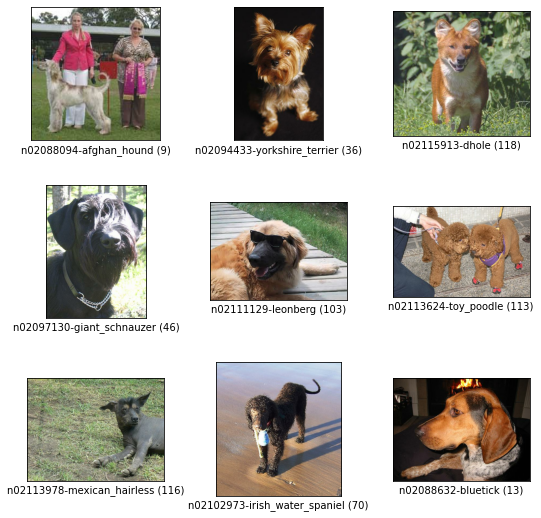

In [4]:
fig = tfds.show_examples(ds_info, ds_train)

## (2) Agumentation 적용하기 


### 텐서플로우 Random Augmentation API 사용하기
---
augmentation 함수들은 아래와 같습니다.

- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

### 전처리 함수 / 이미지 변환

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

-  이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것입니다.

### Augmentation함수 
- `random_flip_left_right()`과 `random_brightness()`를 활용

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Random Augmentation 직접 구현하기

------
 `tf.image`의 다양한 함수들을 이용해서 직접 augmentation 기법을 랜덤하게 적용하는 `augment2()` 함수

In [8]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

## (3) 비교실험 하기 

>  aumentation 적용 데이터 학습 모델과 아닌 모델을 비교 

---

아래 코드는 텐서플로우 케라스의 ResNet50 중 imagenet에 훈련된 모델을 불러옵니다. `include_top`은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문

### ResNet50+imagenet  모델

In [9]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### ResNet50+imagenet+agumentation 모델

In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### Dataset에 agumentation 적용하기 

- apply_normalize_on_dataset()에서 `with_aug`를 `False`로 주어 augmentation이 적용되지 않도록 하고, 
- 다른 하나는 `True`로 주어 augmentation이 적용되도록 합니다.

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

### 학습 시키기 / 검증 

> 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행합니다.

In [12]:
tf.random.set_seed(2020)

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


In [13]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 52s - loss: 5.1398 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0557s vs `on_train_batch_end` time: 0.0842s). Check your callbacks.


750/750 [==============================] - 109s 145ms/step - loss: 2.2250 - accuracy: 0.4413 - val_loss: 3.5862 - val_accuracy: 0.1750
Epoch 2/20
750/750 [==============================] - 109s 146ms/step - loss: 0.7783 - accuracy: 0.7820 - val_loss: 1.1437 - val_accuracy: 0.6606
Epoch 3/20
750/750 [==============================] - 109s 146ms/step - loss: 0.2589 - accuracy: 0.9427 - val_loss: 1.0044 - val_accuracy: 0.7095
Epoch 4/20
750/750 [==============================] - 110s 146ms/step - loss: 0.0720 - accuracy: 0.9920 - val_loss: 0.9384 - val_accuracy: 0.7329
Epoch 5/20
750/750 [==============================] - 110s 146ms/step - loss: 0.0450 - accuracy: 0.9963 - val_loss: 0.9414 - val_accuracy: 0.7407
Epoch 6/20
750/750 [==============================] - 110s 146ms/step - loss: 0.0376 - accuracy: 0.9970 - val_loss: 0.9719 - val_accuracy: 0.7339
Epoch 7/20
750/750 [==============================] - 110s 146ms/step - loss: 0.0183 - accuracy: 0.9989 - val_loss: 0.9436 - val_accura

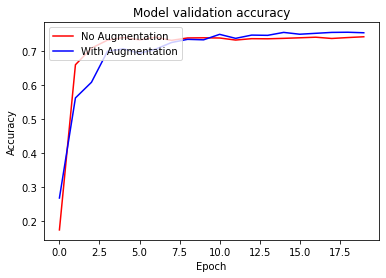

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

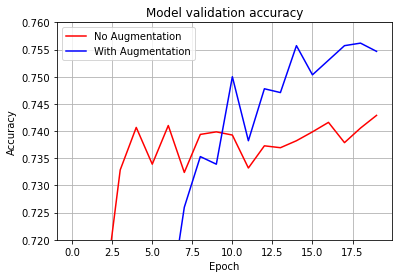

In [15]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

#  심화 기법 
## (1) Cutmix Augmentation




> **주요 참고 자료**
>
> - [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
> - [Chris Deotte's CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)

- *CutMix*는 네이버 클로바(CLOVA)에서 발표한 *CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features* 에서 제안된 방법입니다. 이름인 *CutMix*를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다.

- *Mixup*은 특정 비율로 픽셀별 값을 섞는 방식이고, *Cutout*은 이미지를 잘라내는 방식입니다. *CutMix*는 *Mixup*과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다. 

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-2-P-2.max-800x600.png)

### 1) 이미지 섞기 / Cut Mix

------

가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해 봅시다. 배치 내의 이미지를 두 개 골라서 섞어줍니다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부릅니다.

예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 보겠습니다.

In [16]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes
num_classes

120

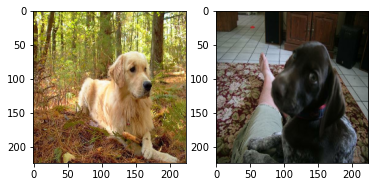

In [17]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

### Clib Box 위치 함수 

이 중 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 봅시다.

In [18]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(14, shape=(), dtype=int32) tf.Tensor(86, shape=(), dtype=int32) tf.Tensor(180, shape=(), dtype=int32)


### Mix Image 함수

바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.



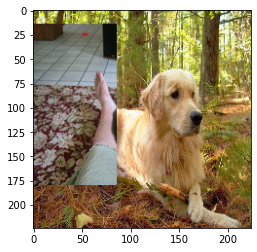

In [19]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

### 2) 라벨 섞기

------

이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 합니다. 
그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 합니다.

- *CutMix*에서는 면적에 비례해서 라벨을 섞어줍니다. 
- 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 
- 예를 들어 A 클래스를 가진 원래 이미지 `image_a`와 B 클래스를 가진 이미지 `image_b`를 섞을 때 `image_a`를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다. 
- 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.

In [20]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.7154815 , 0.        , 0.        , 0.28451848,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

위에서 구현한 두 함수 mix_2_image()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 봅시다.

### Cutmix 함수 

In [21]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 4-6. 심화 기법 
## (2) Mixup Augmentation

> **주요 참고 자료**
>
> - [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)

*Mixup*은 위에서 보여드린 *CutMix*보다 간단하게 이미지와 라벨을 섞어줍니다. *mixup: Beyond Empirical Risk Minimization*은 위에서 본 *CutMix* 비교 표에서 "Mixup"이라는 방법이 제안된 논문입니다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 *CutMix*보다 구현이 간단하다고 볼 수 있습니다.

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-2-P-3.max-800x600.png)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.7154815  0.         0.         0.28451848
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

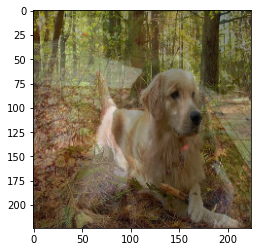

In [22]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.

### Mixup 함수 

In [23]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [24]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [25]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
    
        onehot_imgs.append(image[i])
        onehot_labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    return onehot_imgs, onehot_labels

# 프로젝트: CutMix 또는 Mixup 비교실험 하기

### 1. Augmentation을 적용한 데이터셋 만들기

------

데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

In [26]:
# 기본 Augmentation / Cutmix / Mixup
def apply_normalize_on_dataset(ds, is_test=False, 
                               batch_size=16, with_aug=False, 
                               with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 데이터셋에 CutMix 또는 Mixup augmentation을 적용

In [27]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

In [29]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

### 2. 모델 만들기

------

비교실험을 위한 모델 두 개를 만들기, 모델은 ResNet-50을 사용한다.

### Cut Mix model 

In [30]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

###  Mixup model

In [31]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 3. Cutmix/ Mixup모델 훈련하기

------

모델을 훈련시켜 주세요.

위에서 만든 *CutMix*나 *Mixup*을 사용하기 위해서는 앞에서 `resnet50`과 `aug_resnet50`을 훈련하는 데 사용했던 `sparse_categorical_crossentropy()` 대신 `categorical_crossentropy()`를 사용!

In [32]:
tf.random.set_seed(2020)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [33]:

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [34]:
ds_train_cutmix

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [35]:
history_resnet50_cut_mix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:23 - loss: 5.2234 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0467s vs `on_train_batch_end` time: 0.0804s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.8133 - accuracy: 0.2128WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0067s vs `on_test_batch_end` time: 0.0297s). Check your callbacks.


750/750 [==============================] - 114s 151ms/step - loss: 3.8133 - accuracy: 0.2128 - val_loss: 3.8435 - val_accuracy: 0.1350
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 2.9422 - accuracy: 0.4276 - val_loss: 1.4817 - val_accuracy: 0.5911
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 2.6479 - accuracy: 0.5203 - val_loss: 1.2861 - val_accuracy: 0.6409
Epoch 4/20
750/750 [==============================] - 114s 152ms/step - loss: 2.4415 - accuracy: 0.5862 - val_loss: 1.4065 - val_accuracy: 0.6196
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 2.2739 - accuracy: 0.6378 - val_loss: 1.1914 - val_accuracy: 0.6763
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 2.1792 - accuracy: 0.6677 - val_loss: 1.1249 - val_accuracy: 0.6903
Epoch 7/20
750/750 [==============================] - 114s 152ms/step - loss: 2.0776 - accuracy: 0.7007 - val_loss: 1.2454 - val_accura

In [36]:
history_resnet50_mix_up = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:21 - loss: 5.1964 - accuracy: 0.0625WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0469s vs `on_train_batch_end` time: 0.0803s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.7364 - accuracy: 0.2352WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0068s vs `on_test_batch_end` time: 0.0293s). Check your callbacks.


750/750 [==============================] - 115s 154ms/step - loss: 3.7364 - accuracy: 0.2352 - val_loss: 3.7749 - val_accuracy: 0.1374
Epoch 2/20
750/750 [==============================] - 115s 153ms/step - loss: 2.8879 - accuracy: 0.4697 - val_loss: 1.5325 - val_accuracy: 0.5764
Epoch 3/20
750/750 [==============================] - 115s 153ms/step - loss: 2.6219 - accuracy: 0.5699 - val_loss: 1.3070 - val_accuracy: 0.6299
Epoch 4/20
750/750 [==============================] - 115s 153ms/step - loss: 2.4296 - accuracy: 0.6395 - val_loss: 1.2713 - val_accuracy: 0.6510
Epoch 5/20
750/750 [==============================] - 115s 153ms/step - loss: 2.2972 - accuracy: 0.6988 - val_loss: 1.2574 - val_accuracy: 0.6514
Epoch 6/20
750/750 [==============================] - 115s 153ms/step - loss: 2.1946 - accuracy: 0.7295 - val_loss: 1.2926 - val_accuracy: 0.6522
Epoch 7/20
750/750 [==============================] - 115s 153ms/step - loss: 2.1023 - accuracy: 0.7595 - val_loss: 1.2042 - val_accura

### 4. 훈련 과정 시각화하기

------


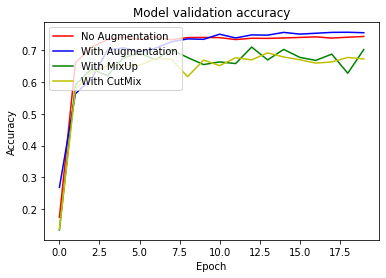

In [37]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cut_mix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mix_up.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With MixUp', 'With CutMix'], loc='upper left')
plt.show()

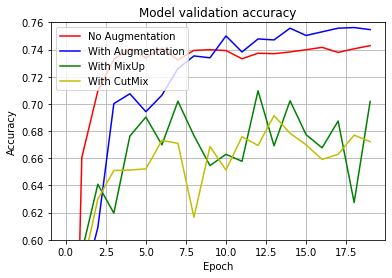

In [38]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cut_mix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mix_up.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With MixUp', 'With CutMix'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()

### 5. Augmentation에 의한 모델 성능 비교

------

No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.